In [125]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
    
)
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.preprocessing as sp
import pickle
import matplotlib.pyplot as plt
import scipy
import os
import time
from datetime import date
# import dask.dataframe as dd
# import dask.config
# dask.config.set({"distributed.scheduler.allowed-failures": 10})
today = date.today()
import os
import sys
sys.path.insert(0, '/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/') 
from singlecell.read import read_single_cell_sql
from singlecell.preprocess import handle_nans, extract_cpfeature_names,find_highly_correlated_features
from singlecell.visualize import visualize_n_SingleCell, cluster
from singlecell.process import statistical_tests,precision_recall
from singlecell.preprocess.filter_out_edge_single_cells import edgeCellFilter
from singlecell.save.save_pandas_dfs import saveDF_to_CSV_GZ_no_timestamp
from singlecell.preprocess.control_for_cellcount import control_feature_y_for_variable_x
from singlecell.process.replicate_correlation import replicate_null_corr_coefs
from singlecell.process import normalize_funcs


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
########################## Project root directory and path to results ########################
mito_project_root_dir = "/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/"
save_results_dir = mito_project_root_dir + "/workspace/results/jump_fq/"

In [137]:
# ########## jump_orf/jump_crispr/jump_compound

plates = pd.read_csv(
    mito_project_root_dir + "/workspace/metadata/JUMP/plate.csv.gz"
)
wells = pd.read_csv(
    mito_project_root_dir + "/workspace/metadata/JUMP/well.csv.gz"
)
compound = pd.read_csv(
    mito_project_root_dir + "/workspace/metadata/JUMP/compound.csv.gz"
)
orf = pd.read_csv(
    mito_project_root_dir + "/workspace/metadata/JUMP/orf.csv.gz"
)
crispr = pd.read_csv(
    mito_project_root_dir + "/workspace/metadata/JUMP/crispr.csv.gz"
)

compound_plates = plates[
    plates["Metadata_PlateType"] == "COMPOUND"
].reset_index(drop=True)

dataset = "jump_orf"
annot_orf = wells.merge(orf, on=["Metadata_JCP2022"]).merge(
    plates, on=["Metadata_Plate", "Metadata_Source"]
)
annot_orf["Batch"] = annot_orf["Metadata_Batch"]
annot_orf["batch_plate"] = (
    annot_orf["Metadata_Batch"] + "-" + annot_orf["Metadata_Plate"]
)
annot_orf["ctrl_well"] = annot_orf["Metadata_Symbol"].isin(
    ["LacZ", "BFP", "HcRed", "LUCIFERASE"]
)

if 0:
    annot_orf.to_csv(
        mito_project_root_dir
        + "/workspace/metadata/preprocessed/annot_"
        + dataset
        + ".csv"
    )

dataset = "jump_crispr"
annot_crispr = wells.merge(crispr, on=["Metadata_JCP2022"]).merge(
    plates, on=["Metadata_Plate", "Metadata_Source"]
)
annot_compound = wells.merge(compound, on=["Metadata_JCP2022"]).merge(
    compound_plates, on=["Metadata_Plate", "Metadata_Source"]
)

annot_crispr["Batch"] = annot_crispr["Metadata_Batch"]
annot_crispr["batch_plate"] = (
    annot_crispr["Metadata_Batch"] + "-" + annot_crispr["Metadata_Plate"]
)
annot_compound["batch_plate"] = (
    annot_compound["Metadata_Batch"] + "-" + annot_compound["Metadata_Plate"]
)
annot_compound["Batch"] = annot_compound["Metadata_Batch"]

annot_crispr["ctrl_well"] = annot_crispr["Metadata_Symbol"].isin(
    ["non-targeting"]
)


annot_compound["ctrl_well"] = annot_compound["Metadata_JCP2022"].isin(
    ["JCP2022_033924"]
)

if 0:
    annot_crispr.to_csv(
        mito_project_root_dir
        + "/workspace/metadata/preprocessed/annot_"
        + dataset
        + ".csv"
    )

    dataset = "jump_compound"
    ## annot['ctrl_well']=annot['Symbol'].isin(['LacZ'])
    annot_compound.to_csv(
        mito_project_root_dir
        + "/workspace/metadata/preprocessed/annot_"
        + dataset
        + ".csv"
    )

In [138]:
    dataset = "jump_compound"
    ## annot['ctrl_well']=annot['Symbol'].isin(['LacZ'])
    annot_compound.to_csv(
        mito_project_root_dir
        + "/workspace/metadata/preprocessed/annot_"
        + dataset
        + ".csv"
    )

In [ ]:
set()

In [123]:
JUMPCP_compound_library = pd.read_csv(
    mito_project_root_dir + "/workspace/metadata/JUMP-COMPOUND/2022_10_18_JUMP-CP_compound_library.csv"
)

repurposing_samples_standardized = pd.read_csv(
    mito_project_root_dir + "/workspace/metadata/JUMP-COMPOUND/repurposing_samples_20200324_standardized.csv"
)

merged_on_inchkey=JUMPCP_compound_library.merge(repurposing_samples_standardized,\
                                                on=["InChIKey_standardized","InChIKey","InChI_standardized"],\
                                                how='left')

/tmp/ipykernel_89903/3880974612.py:1: DtypeWarning: Columns (7,8,15) have mixed types. Specify dtype option on import or set low_memory=False.
  JUMPCP_compound_library = pd.read_csv(


In [124]:
merged_on_inchkey.shape

(127761, 28)

In [114]:
JUMPCP_compound_library.shape, repurposing_samples_standardized.shape, merged_on_inchkey.shape

((121869, 16), (13521, 15), (20031, 30))

In [60]:
# # ########## lincs
dataset = "lincs_g"
# annot=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/raw-profiles/CP_LINCS/metadata/matadata_lincs.csv")
annot0 = pd.read_csv(
    mito_project_root_dir
    + "/workspace/metadata/lincs/DrugRepurposing_Metadata.csv"
)
annot = pd.read_csv(
    mito_project_root_dir + "/workspace/metadata/LINCS_meta.csv"
)
annot = annot.merge(
    annot0[["Metadata_Plate", "Metadata_Well", "Metadata_pert_name"]],
    how="left",
    on=["Metadata_Plate", "Metadata_Well"],
)
annot["Batch"] = "2016_04_01_a549_48hr_batch1"
annot["batch_plate"] = annot["Batch"] + "-" + annot["Metadata_Plate"]
annot["Image_Metadata_Well"] = annot["Metadata_Well"]
annot["Image_Metadata_Plate"] = annot["Metadata_Plate"]
annot["ctrl_well"] = annot["Metadata_pert_type"].isin(["control"])
# annot['pert_id']=annot['Metadata_pert_id_dose']
annot.to_csv(
    mito_project_root_dir
    + "/workspace/metadata/preprocessed/annot_"
    + dataset
    + ".csv"
)

In [126]:
import pandas as pd
from sqlalchemy import create_engine
from functools import reduce
import gc


def read_per_well_data(
    input_data_dir,
    annot,
    prof_workspace_folder_name="profiles",
    fformat=".parquet",
):
    batches = annot["Batch"].unique()

    df_agg_all_batches_ls = []
    for b in batches:
        print(b)
        #         if "Metadata_Source" in annot.columns:
        source_str = annot.loc[
            annot["Batch"] == b, "Metadata_Source"
        ].unique()[0]
        #             print(source_str)
        profile_path = (
            input_data_dir
            + source_str
            + "/workspace/"
            + prof_workspace_folder_name
            + "/"
        )
        #         else:
        #             profile_path = input_data_dir + "/workspace/profiles/"

        df_sag_ls = []
        plates_exist = os.listdir(profile_path + b)
        plates_meta = annot.loc[annot["Batch"] == b, "Metadata_Plate"].unique()
        plates = set(plates_meta) & set(plates_exist)
        for p in plates:
            print(p)

            fileName = profile_path + b + "/" + p + "/" + p + fformat
            #             print(fileName)
            if os.path.exists(fileName):
                if fformat == ".parquet":
                    sc_df = pd.read_parquet(fileName)
                elif fformat in [".csv", ".csv.gz"]:
                    sc_df = pd.read_csv(fileName)

                #         per_site_aggregate=sc_df.groupby(['Metadata_Well','Metadata_Site']).mean()[feature_list+['Count_Cells']].reset_index()
                sc_df["Metadata_Batch"] = b
                sc_df["Metadata_Plate"] = p
                df_sag_ls.append(sc_df)
                del sc_df
                gc.collect()
            else:
                print(fileName, " not exists")

        if df_sag_ls:
            df_sag = pd.concat(df_sag_ls, axis=0)
            df_agg_all_batches_ls.append(df_sag)

    df_agg_all_batches = pd.concat(
        df_agg_all_batches_ls, axis=0, ignore_index=True
    )
    return df_agg_all_batches

In [4]:
lincs_meta_cols = [
    "Metadata_broad_sample",
    "Metadata_dose_recode",
    "Metadata_pert_id",
    "Metadata_pert_mfc_id",
    "Metadata_InChIKey14",
    "Metadata_pert_type",
    "Metadata_moa",
    "Metadata_target",
    "Metadata_pert_id_dose",
    "Metadata_pert_name",
]

# lincs_meta_cols=['Metadata_broad_sample','Metadata_dose_recode','Metadata_pert_id','Metadata_pert_mfc_id',\
# 'Metadata_InChIKey14','Metadata_pert_type','Metadata_pert_id_dose']

cdrp_meta_cols = [
    "Metadata_broad_sample",
    "Metadata_mmoles_per_liter2",
    "Metadata_pert_id",
    "Metadata_Sample_Dose",
    "Metadata_moa",
]
jumporf_meta_cols = ["Symbol", "broad_sample"]
jumpcrispr_meta_cols = ["Metadata_NCBI_Gene_ID", "Metadata_Symbol"]
jumpcompound_meta_cols = ["Metadata_InChIKey", "Metadata_InChI"]
taorf_meta_cols = [
    "Metadata_gene_name",
    "Metadata_pert_name",
    "Metadata_broad_sample",
    "Metadata_moa",
]


# jump_orf_params={'profiles_path':"/home/ubuntu/jumpbucket/projects/2021_04_26_Production/workspace/backend/",\
#                  'meta_cols':jumporf_meta_cols,\
#                  'pert_col':'broad_sample',\
#                  'target_features_list':target_features_list_orf_cdrp
#                 }

jump_orf_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0016-jump/",
    "prof_workspace_folder_name": "profiles",
    "pformat": ".parquet",
    "meta_cols": jumporf_meta_cols,
    "pert_col": "Metadata_JCP2022",
    "untreated_key_val": ["Metadata_pert_type", "negcon"],
}

cdrp_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0012-wawer-bioactivecompoundprofiling/",
    "prof_workspace_folder_name": "profiles",
    "pformat": ".csv.gz",
    "meta_cols": cdrp_meta_cols,
    "pert_col": "Metadata_Sample_Dose",
    "untreated_key_val": ["Metadata_pert_type", "control"],
}


# /home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace/backend/
# https://cellpainting-gallery.s3.amazonaws.com/cpg0004-lincs/broad/workspace/backend/2016_04_01_a549_48hr_batch1/SQ00014812
lincs_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0004-lincs/",
    "prof_workspace_folder_name": "backend",
    "pformat": ".csv",
    "meta_cols": lincs_meta_cols,
    "pert_col": "Metadata_pert_id_dose",
    "untreated_key_val": ["Metadata_pert_type", "control"],
}

jump_crispr_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0016-jump/",
    "prof_workspace_folder_name": "profiles",
    "pformat": ".parquet",
    "meta_cols": jumpcrispr_meta_cols,
    "pert_col": "Metadata_JCP2022",
    "untreated_key_val": ["Metadata_Symbol", "non-targeting"],
}

jump_compound_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0016-jump/",
    "prof_workspace_folder_name": "profiles",
    "pformat": ".parquet",
    "meta_cols": jumpcompound_meta_cols,
    "pert_col": "Metadata_JCP2022",
    "untreated_key_val": ["Metadata_JCP2022", "JCP2022_999999"],
}

ta_orf_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0017-rohban-pathways/",
    "prof_workspace_folder_name": "profiles",
    "pformat": ".csv.gz",
    "meta_cols": taorf_meta_cols,
    "pert_col": "Metadata_broad_sample",
    "untreated_key_val": ["Metadata_pert_type", "Untreated"],
}

ds_info_dict = {
    "jump_orf": jump_orf_params,
    "CDRP": cdrp_params,
    "lincs": lincs_params,
    "lincs_g": lincs_params,
    "jump_crispr": jump_crispr_params,
    "jump_compound": jump_compound_params,
    "taorf": ta_orf_params,
}
# 'broad_sample', 'pert_type', 'control_type'

# results=annot[['Symbol','broad_sample', 'pert_type', 'control_type']].drop_duplicates().reset_index(drop=True)

# dataset='CDRP';dataset_meta_hue='Metadata_moa'
# dataset='lincs';dataset_meta_hue='Metadata_moa'
# dataset='jump_orf';dataset_meta_hue='Symbol'

In [ ]:
ls /home/ubuntu/gallery/cpg0017-rohban-pathways/broad/workspace/profiles/2013_10_11_SIGMA2_Pilot

In [28]:
ls 

Batch1_20221004/  Batch3_20221010/  Batch5_20221030/
Batch2_20221006/  Batch4_20221012/  Batch6_20221102/


In [ ]:
annot_crispr["Metadata_Symbol"].unique()

In [ ]:
# annot_crispr.groupby(['Metadata_Batch','Metadata_Source']).size()

In [ ]:
# annot_compound.groupby(['Metadata_Batch','Metadata_Source']).size()

In [99]:
dataset = "jump_crispr"
dataset = "jump_compound"
# dataset = "jump_orf"
# dataset = "lincs"
# dataset="taorf"
# dataset = "CDRP"

##################### Read preprocessed metadata
annot = pd.read_csv(
    mito_project_root_dir
    + "/workspace/metadata/preprocessed/annot_"
    + dataset
    + ".csv",
    dtype={"Metadata_Plate": str},
)
# annot["Metadata_pert_type"]
annot

,Unnamed: 0,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Batch,Metadata_PlateType,batch_plate,Batch
0,0,source_1,UL000081,A02,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,Batch4_20221012,COMPOUND,Batch4_20221012-UL000081,Batch4_20221012
1,1,source_1,UL000081,A04,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,Batch4_20221012,COMPOUND,Batch4_20221012-UL000081,Batch4_20221012
2,2,source_1,UL000081,A45,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,Batch4_20221012,COMPOUND,Batch4_20221012-UL000081,Batch4_20221012
3,3,source_1,UL000081,A47,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,Batch4_20221012,COMPOUND,Batch4_20221012-UL000081,Batch4_20221012
4,4,source_1,UL000081,AA02,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,Batch4_20221012,COMPOUND,Batch4_20221012-UL000081,Batch4_20221012
...,...,...,...,...,...,...,...,...,...,...,...
819711,819711,source_10,Dest210823-174422,N23,JCP2022_999999,NaN,NaN,2021_08_23_U2OS_48_hr_run18,COMPOUND,2021_08_23_U2OS_48_hr_run18-Dest210823-174422,2021_08_23_U2OS_48_hr_run18
819712,819712,source_10,Dest210823-174422,O02,JCP2022_999999,NaN,NaN,2021_08_23_U2OS_48_hr_run18,COMPOUND,2021_08_23_U2OS_48_hr_run18-Dest210823-174422,2021_08_23_U2OS_48_hr_run18
819713,819713,source_10,Dest210823-174422,O23,JCP2022_999999,NaN,NaN,2021_08_23_U2OS_48_hr_run18,COMPOUND,2021_08_23_U2OS_48_hr_run18-Dest210823-174422,2021_08_23_U2OS_48_hr_run18
819714,819714,source_10,Dest210823-174422,P02,JCP2022_999999,NaN,NaN,2021_08_23_U2OS_48_hr_run18,COMPOUND,2021_08_23_U2OS_48_hr_run18-Dest210823-174422,2021_08_23_U2OS_48_hr_run18


In [109]:
annot[["Batch","Metadata_Source"]].drop_duplicates().groupby(["Batch","Metadata_Source"]).size().max()

1

In [108]:
annot['Batch']

0                     Batch4_20221012
1                     Batch4_20221012
2                     Batch4_20221012
3                     Batch4_20221012
4                     Batch4_20221012
                     ...             
819711    2021_08_23_U2OS_48_hr_run18
819712    2021_08_23_U2OS_48_hr_run18
819713    2021_08_23_U2OS_48_hr_run18
819714    2021_08_23_U2OS_48_hr_run18
819715    2021_08_23_U2OS_48_hr_run18
Name: Batch, Length: 819716, dtype: object

In [192]:
annot["Metadata_pert_type"].unique()

array(['trt', 'control'], dtype=object)

In [ ]:
annot[annot["Metadata_JCP2022"] == "JCP2022_999999"].groupby(
    "Metadata_Source"
).size()

## some usefull stats
- jump-orf
   - cp_features: 3578
   - cp_features_analysis/nan cols/low vars: 3419 0 159
   - before dropping nan rows:  (91001, 4607)
   - after dropping nan rows:  (90997, 4607)
   
- jump-compound source 1
   - cp_features: 3673
   - cp_features_analysis/nan cols/low vars: 3392 0 186
   - before dropping nan rows:  (74843, 4580)
   - after dropping nan rows:  (74049, 4580) 
   
   
- taorf   
    - cp_features: 3587
    - len cp_features_analysis/nan cols/low vars: 3362 0 225
    - before dropping nan rows:  (1918, 4436)
    - after dropping nan rows:  (1916, 4436)
    
- CDRP
   - len cp_features_analysis/nan cols/low vars: 3385 0 207
   - before dropping nan rows:  (153010, 4519)
   - after dropping nan rows:  (152976, 4519)

In [50]:
df_agg_all_batches.shape, df_sag.shape

((52223, 1787), (52223, 1671))

In [ ]:
    common_cols_2merge = list(set(annot_source.columns) & set(df_sag.columns))
    df_sag["Metadata_Plate"] = df_sag["Metadata_Plate"].astype(str)
    df_sag = pd.merge(df_sag, annot_source, how="inner", on=common_cols_2merge)

In [59]:
# annot_source.shape, df_sag.shape
df_sag.groupby(["Metadata_Plate", "Image_Metadata_Well"]).size()

Metadata_Plate  Image_Metadata_Well
SQ00014812      A01                    1
                A02                    1
                A03                    1
                A04                    1
                A05                    1
                                      ..
SQ00015233      P20                    1
                P21                    1
                P22                    1
                P23                    1
                P24                    1
Length: 52223, dtype: int64

In [215]:
annot = pd.read_csv(
    mito_project_root_dir
    + "/workspace/metadata/preprocessed/annot_"
    + dataset
    + ".csv",
    dtype={"Metadata_Plate": str},
)

if dataset == "CDRP":
    annot["Metadata_Well"] = annot["Metadata_Well"].str.upper()

/tmp/ipykernel_26964/3285421936.py:1: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  annot = pd.read_csv(


In [29]:
# annot['ctrl_well'].unique()

df_rep_level_scaled["Metadata_Sample_Dose"]

0                               negcon
1                               negcon
2          BRD-K57190272-001-05-6_10.0
3          BRD-K33239740-001-06-2_10.0
4          BRD-K86861413-001-08-1_10.0
                      ...             
152981     BRD-K81884775-001-01-5_9.97
152982     BRD-K70378808-001-01-2_10.0
152983     BRD-K18294143-001-01-0_10.0
152984    BRD-K81706364-001-01-7_10.07
152985     BRD-K75076471-001-01-3_9.22
Name: Metadata_Sample_Dose, Length: 152986, dtype: object

In [45]:
ls /home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/results/jump_fq/preprocessed_data

CDRP_df_rep_level_scaled_broad.csv*
jump_compound_df_rep_level_scaled_source_10.csv*
jump_compound_df_rep_level_scaled_source_11.csv*
jump_compound_df_rep_level_scaled_source_1.csv*
jump_compound_df_rep_level_scaled_source_2.csv*
jump_compound_df_rep_level_scaled_source_3.csv*
jump_compound_df_rep_level_scaled_source_5.csv*
jump_compound_df_rep_level_scaled_source_6.csv*
jump_compound_df_rep_level_scaled_source_7.csv*
jump_compound_df_rep_level_scaled_source_8.csv*
jump_compound_df_rep_level_scaled_source_9.csv*
jump_crispr_df_rep_level_scaled_source_13.csv*
jump_orf_df_rep_level_scaled_source_4.csv*
lincs_g_df_rep_level_scaled_broad.csv*
taorf_df_rep_level_scaled_broad.csv*


In [51]:
%time

# dataset = "jump_orf"
# dataset = "CDRP"
# dataset='lincs'
# dataset="jump_crispr"
dataset = "jump_compound"
# dataset = "lincs_g"

##################### Read preprocessed metadata
annot = pd.read_csv(
    mito_project_root_dir
    + "/workspace/metadata/preprocessed/annot_"
    + dataset
    + ".csv",
    dtype={"Metadata_Plate": str},
)

if dataset == "CDRP":
    annot["Metadata_Well"] = annot["Metadata_Well"].str.upper()

# annot = annot[annot["Metadata_Batch"] == "2021_04_26_Batch1"].reset_index(
#     drop=True
# )

# target_features_list = ds_info_dict[dataset]["target_features_list"]

if "Metadata_Source" not in annot.columns:
    annot["Metadata_Source"] = "broad"

sources = annot["Metadata_Source"].unique()
sources=['source_9']
for si in sources:
    annot_source = annot[annot["Metadata_Source"] == si].reset_index()

    if 0:
        ##################### Read per well data
        #     if dataset in [
        #         "lincs",
        #         "lincs_g",
        #         "taorf",
        #     ]:  # for this batch of lincs data we dont have well level profiles
        #         df_agg_all_batches = sample_single_cells_from_sql(
        #             ds_info_dict[dataset]["profiles_path"], annot_source
        #         )
        df_agg_all_batches = read_per_well_data(
            ds_info_dict[dataset]["profiles_path"],
            annot_source,
            ds_info_dict[dataset]["prof_workspace_folder_name"],
            fformat=ds_info_dict[dataset]["pformat"],
        )
        #     else:
        #         #     df_agg_all_batches=read_per_well_data_csvs(ds_info_dict[dataset]["profiles_path"],annot);
        #         df_agg_all_batches = read_per_well_data(
        #             ds_info_dict[dataset]["profiles_path"],
        #             annot_source,
        #             ds_info_dict[dataset]["prof_workspace_folder_name"],
        #             fformat=".parquet",
        #         )

        ##################### Clean and shrink features
        (
            cp_features,
            cp_features_analysis_0,
        ) = extract_cpfeature_names.extract_cpfeature_names(df_agg_all_batches)
        df_sag, cp_features_analysis = handle_nans.handle_nans(
            df_agg_all_batches,
            cp_features_analysis_0,
            thrsh_null_ratio=0.05,
            thrsh_std=0.001,
            fill_na_method="drop-rows",
        )

        ##################### merge all aggregated profiles with annot
        common_cols_2merge = list(
            set(annot_source.columns) & set(df_sag.columns)
        )
        df_sag["Metadata_Plate"] = df_sag["Metadata_Plate"].astype(str)
        df_sag = pd.merge(
            df_sag, annot_source, how="inner", on=common_cols_2merge
        )

        ##################### normalize to negative control
        if 0:
            df_sag_zscored = (
                normalize_funcs.zscore_df_columns_by_control_perPlate(
                    df_sag,
                    cp_features_analysis,
                    "Standard",
                    "batch_plate",
                    ds_info_dict[dataset]["untreated_key_val"],
                )
            )

            df_sag_zscored = df_sag_zscored[
                ds_info_dict[dataset]["untreated_key_val"][0]
                != ds_info_dict[dataset]["untreated_key_val"][1]
            ].reset_index()
        else:
            df_sag_zscored = df_sag.copy()

        ##################### per plate standardization
        df_rep_level_scaled = normalize_funcs.standardize_per_catX(
            df_sag_zscored, "batch_plate", cp_features_analysis
        ).copy()

        ##################### save data
        df_rep_level_scaled[cp_features_analysis] = df_rep_level_scaled[
            cp_features_analysis
        ].astype("float32")

        df_rep_level_scaled.to_csv(
            save_results_dir
            + "/preprocessed_data/"
            + dataset
            + "_df_rep_level_scaled_"
            + si
            + ".csv",
            index=False,
        )

    else:
        df_rep_level_scaled = pd.read_csv(
            save_results_dir
            + "/preprocessed_data/"
            + dataset
            + "_df_rep_level_scaled_"
            + si
            + ".csv"
        )

        (
            cp_features,
            cp_features_analysis,
        ) = extract_cpfeature_names.extract_cpfeature_names(
            df_rep_level_scaled
        )
    ##################### calculate and save replication correlatiopn curves
    pert_col = ds_info_dict[dataset]["pert_col"]
    nOfReps = df_rep_level_scaled.groupby([pert_col]).size().reset_index()
    pairWithReplicates = nOfReps.loc[nOfReps[0] != 1, :].reset_index()[
        pert_col
    ]  # .groupby([0]).size()

    df_rep_level_scaled = df_rep_level_scaled[
        df_rep_level_scaled[ds_info_dict[dataset]["untreated_key_val"][0]]
        != ds_info_dict[dataset]["untreated_key_val"][1]
    ].reset_index(drop=True)

    if 0:
        fh_2save, repCorrDf = replicate_null_corr_coefs(
            df_rep_level_scaled[
                df_rep_level_scaled[pert_col].isin(pairWithReplicates)
            ].reset_index(drop=True),
            pert_col,
            cp_features_analysis,
            1,
            title="",
            hist_bins=50,
        )

        fh_2save.savefig(
            save_results_dir
            + "/corr_curves/"
            + dataset
            + "_corr_curves_"
            + si
            + ".png"
        )
        repCorrDf.to_csv(
            save_results_dir
            + "/corr_csvs/"
            + dataset
            + "_corr_df_"
            + si
            + ".csv",
            index=False,
        )

    ##################### calculate and save feature quality rannkings
    #     df_rep_level_scaled2 = (
    #         df_rep_level_scaled.groupby([pert_col, "batch_plate"])
    #         .mean()
    #         .reset_index()
    #     )

    df_rep_level_scaled2 = df_rep_level_scaled[
        df_rep_level_scaled[pert_col].isin(pairWithReplicates)
    ].reset_index(drop=True)

    DS_featureQ_rank = pd.DataFrame(
        data=df_rep_level_scaled2.groupby(pert_col)[cp_features_analysis]
        .std()
        .mean(),
        index=cp_features_analysis,
        columns=["average_std_score"],
    )

    batches = annot_source["Batch"].unique()
    for b in batches:
        df_rep_per_batch = df_rep_level_scaled2[
            df_rep_level_scaled2["Batch"] == b
        ].reset_index(drop=True)
        nOfReps = df_rep_per_batch.groupby([pert_col]).size().reset_index()
        pairWithReplicates_batch = nOfReps.loc[
            nOfReps[0] != 1, :
        ].reset_index()[pert_col]
        df_rep_per_batch2 = df_rep_per_batch[
            df_rep_per_batch[pert_col].isin(pairWithReplicates_batch)
        ].reset_index(drop=True)

        DS_featureQ_rank["average_std_score_" + b] = (
            df_rep_per_batch2.groupby(pert_col)[cp_features_analysis]
            .std()
            .mean()
        )

    DS_featureQ_rank2 = (
        DS_featureQ_rank.sort_values(by="average_std_score", ascending=True)
        .reset_index()
        .rename(columns={"index": "features"})
    )

    DS_featureQ_rank2.to_csv(
        save_results_dir
        + "/fq_csvs/"
        + dataset
        + "_feature_quality_"
        + si
        + ".csv",
        index=False,
    )

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.58 µs


ValueError: could not convert string to float: 'source_9'

In [53]:
pert_col

'Metadata_JCP2022'

In [12]:
common_cols_2merge = list(set(annot_source.columns) & set(df_sag.columns))
common_cols_2merge

['Metadata_Well', 'Metadata_Plate']

In [19]:
df_sag[['Metadata_Well', 'Metadata_Plate']].dtypes

Metadata_Well     object
Metadata_Plate    object
dtype: object

In [22]:
df_sag["Metadata_Plate"] = df_sag["Metadata_Plate"].astype(str)
df_sag["Metadata_Plate"] = df_sag["Metadata_Plate"].astype(str)
x=pd.merge(df_sag, annot_source, how="inner", on=common_cols_2merge)
x[x["ctrl_well"]]


,Metadata_Plate,Metadata_Well,Metadata_Site_Count,Metadata_Count_Cells,Metadata_Count_CellsIncludingEdges,Metadata_Count_Cytoplasm,Metadata_Count_Nuclei,Metadata_Count_NucleiIncludingEdges,Metadata_Object_Count,Image_Granularity_10_AGP,...,Metadata_pert_iname,Metadata_pert_iname2,Metadata_moa,Metadata_target,Metadata_mmoles_per_liter2,Metadata_Sample_Dose,Batch,batch_plate,ctrl_well,Metadata_Source
0,25681,A01,6,302,349,302,302,349,302,2.7786,...,NaN,NaN,NaN,NaN,0.0,negcon,CDRP,CDRP-25681,True,broad
1,25681,A02,6,304,352,304,304,352,304,2.0860,...,NaN,NaN,NaN,NaN,0.0,negcon,CDRP,CDRP-25681,True,broad
22,25681,A23,6,296,347,296,296,347,296,2.3551,...,NaN,NaN,NaN,NaN,0.0,negcon,CDRP,CDRP-25681,True,broad
23,25681,A24,6,357,418,357,357,418,357,2.6046,...,NaN,NaN,NaN,NaN,0.0,negcon,CDRP,CDRP-25681,True,broad
24,25681,B01,6,294,355,294,294,355,294,1.7289,...,NaN,NaN,NaN,NaN,0.0,negcon,CDRP,CDRP-25681,True,broad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152927,26006,N14,6,308,364,308,308,364,308,3.3720,...,NaN,NaN,NaN,NaN,0.0,negcon,CDRP,CDRP-26006,True,broad
152948,26006,O11,6,245,275,245,245,275,245,2.7837,...,NaN,NaN,NaN,NaN,0.0,negcon,CDRP,CDRP-26006,True,broad
152949,26006,O12,6,192,223,192,192,223,192,2.6277,...,NaN,NaN,NaN,NaN,0.0,negcon,CDRP,CDRP-26006,True,broad
152972,26006,P11,6,223,246,223,223,246,223,3.2678,...,NaN,NaN,NaN,NaN,0.0,negcon,CDRP,CDRP-26006,True,broad


In [206]:
# df_rep_level_scaled[
#     df_rep_level_scaled[pert_col].isin(pairWithReplicates)
# ].reset_index(drop=True)
# df_agg_all_batches = df_agg_all_batches.reset_index(drop=True)
common_cols_2merge = list(set(annot_source.columns) & set(df_sag.columns))
common_cols_2merge

['Metadata_Plate', 'Metadata_Well']

In [207]:
#     df_sag["Metadata_Plate"] = df_sag["Metadata_Plate"].astype(str)
pd.merge(df_sag, annot_source, how="inner", on=common_cols_2merge)

(0, 4545)

In [210]:
annot_source

,index,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_ASSAY_WELL_ROLE,Metadata_broad_sample,Metadata_mmoles_per_liter,Metadata_solvent,...,Metadata_pert_iname,Metadata_pert_iname2,Metadata_moa,Metadata_target,Metadata_mmoles_per_liter2,Metadata_Sample_Dose,Batch,batch_plate,ctrl_well,Metadata_Source
0,0,24277,a01,24277,H-BIOA-004-3,a01,treated,BRD-K18250272-003-03-7,3.022516,DMSO,...,propoxycaine,propoxycaine,local anesthetic,NaN,6.05,BRD-K18250272-003-03-7_6.05,CDRP,CDRP-24277,False,broad
1,1,24277,a02,24277,H-BIOA-004-3,a02,treated,BRD-K18316707-001-01-9,5.000000,DMSO,...,O-1918,BRD-K18316707,cannabinoid receptor antagonist,NaN,10.00,BRD-K18316707-001-01-9_10.0,CDRP,CDRP-24277,False,broad
2,2,24277,a03,24277,H-BIOA-004-3,a03,treated,BRD-K18438502-001-02-6,5.000000,DMSO,...,NaN,NaN,NaN,NaN,10.00,BRD-K18438502-001-02-6_10.0,CDRP,CDRP-24277,False,broad
3,3,24277,a04,24277,H-BIOA-004-3,a04,treated,BRD-K18550767-001-02-8,5.000000,DMSO,...,bergenin,bergenin,interleukin inhibitor,"IL1B, TNF",10.00,BRD-K18550767-001-02-8_10.0,CDRP,CDRP-24277,False,broad
4,4,24277,a05,24277,H-BIOA-004-3,a05,treated,BRD-K18574842-323-03-3,2.195487,DMSO,...,nafcillin,nafcillin,bacterial cell wall synthesis inhibitor,"CYP1A2, CYP3A4, SLC22A6",4.39,BRD-K18574842-323-03-3_4.39,CDRP,CDRP-24277,False,broad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153381,153381,26795,p20,26795,H-CBLD-004-4,p20,treated,BRD-K17405724-001-01-0,4.916061,DMSO,...,NaN,NaN,NaN,NaN,9.83,BRD-K17405724-001-01-0_9.83,CDRP,CDRP-26795,False,broad
153382,153382,26795,p21,26795,H-CBLD-004-4,p21,treated,BRD-K90170141-001-01-5,4.859274,DMSO,...,NaN,NaN,NaN,NaN,9.72,BRD-K90170141-001-01-5_9.72,CDRP,CDRP-26795,False,broad
153383,153383,26795,p22,26795,H-CBLD-004-4,p22,treated,BRD-K45307499-001-01-7,5.109445,DMSO,...,NaN,NaN,NaN,NaN,10.22,BRD-K45307499-001-01-7_10.22,CDRP,CDRP-26795,False,broad
153384,153384,26795,p23,26795,H-CBLD-004-4,p23,treated,BRD-K84521261-001-01-1,4.958284,DMSO,...,NaN,NaN,NaN,NaN,9.92,BRD-K84521261-001-01-1_9.92,CDRP,CDRP-26795,False,broad


In [204]:
(
    cp_features,
    cp_features_analysis_0,
) = extract_cpfeature_names.extract_cpfeature_names(df_agg_all_batches)
df_sag, cp_features_analysis = handle_nans.handle_nans(
    df_agg_all_batches,
    cp_features_analysis_0,
    thrsh_null_ratio=0.05,
    thrsh_std=0.001,
    fill_na_method="drop-rows",
)

cp_features: 3592
cols2remove_manyNulls []
cols2remove_lowVars ['Nuclei_Intensity_StdIntensityEdge_RNA', 'Nuclei_AreaShape_Zernike_9_7', 'Cells_AreaShape_Zernike_6_4', 'Cells_Intensity_MADIntensity_AGP', 'Cells_AreaShape_Zernike_8_6', 'Cells_Intensity_MADIntensity_DNA', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_9of16', 'Cells_AreaShape_Zernike_9_5', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_2of16', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_5of20', 'Cells_Intensity_MinIntensity_DNA', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_1of16', 'Cytoplasm_Intensity_MinIntensityEdge_DNA', 'Cells_AreaShape_Zernike_5_1', 'Cytoplasm_AreaShape_Zernike_8_8', 'Nuclei_AreaShape_Zernike_6_6', 'Cells_AreaShape_Zernike_5_3', 'Cytoplasm_AreaShape_Zernike_9_7', 'Cytoplasm_Intensity_StdIntensityEdge_Mito', 'Cells_AreaShape_Zernike_7_7', 'Cells_Intensity_StdIntensityEdge_AGP', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of20', 'Nuclei_AreaShape_Zernike_9_3', 'Ce

before dropping nan rows:  (153010, 4519)
after dropping nan rows:  (152976, 4519)


In [72]:
ls /home/ubuntu/gallery/cpg0017-rohban-pathways/broad/workspace/profiles/2013_10_11_SIGMA2_Pilot/41744

41744_augmented.csv.gz*      41744_normalized.csv.gz*
41744_augmented.csv.gz.dvc*  41744_normalized.csv.gz.dvc*
41744.csv.gz*                41744_normalized_feature_select_batch.csv.gz*
41744.csv.gz.dvc*            41744_normalized_feature_select_batch.csv.gz.dvc*


In [33]:
ls /home/ubuntu/gallery/cpg0004-lincs/broad/workspace/backend/2016_04_01_a549_48hr_batch1/SQ00014814

SQ00014814.csv*  SQ00014814.sqlite*


In [8]:
df_rep_level_scaled.to_csv(
    save_results_dir
    + "/preprocessed_data/"
    + dataset
    + "_df_rep_level_scaled_"
    + si
    + ".csv",
    index=False,
)

In [14]:
ls /home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/results/jump_fq/preprocessed_data

jump_compound_df_rep_level_scaled_source_10.csv*
jump_compound_df_rep_level_scaled_source_11.csv*
jump_compound_df_rep_level_scaled_source_1.csv*
jump_compound_df_rep_level_scaled_source_2.csv*
jump_compound_df_rep_level_scaled_source_3.csv*
jump_compound_df_rep_level_scaled_source_5.csv*
jump_compound_df_rep_level_scaled_source_6.csv*
jump_compound_df_rep_level_scaled_source_7.csv*
jump_compound_df_rep_level_scaled_source_8.csv*
jump_compound_df_rep_level_scaled_source_9.csv*
jump_crispr_df_rep_level_scaled_source_13.csv*
jump_orf_df_rep_level_scaled_source_4.csv*
lincs_g_df_rep_level_scaled_broad.csv*
taorf_df_rep_level_scaled_broad.csv*


In [8]:
# dataset = "jump_orf"
# dataset='CDRP'
dataset='lincs'
# dataset="jump_crispr"
# dataset = "jump_compound"
# dataset="taorf"

##################### Read preprocessed metadata
annot = pd.read_csv(
    mito_project_root_dir
    + "/workspace/metadata/preprocessed/annot_"
    + dataset
    + ".csv",
    dtype={"Metadata_Plate": str},
)

df_rep_level_scaled2 = df_rep_level_scaled[
    df_rep_level_scaled[pert_col].isin(pairWithReplicates)
].reset_index(drop=True)

DS_featureQ_rank = pd.DataFrame(
    data=df_rep_level_scaled2.groupby(pert_col)
    .std()
    .mean()[cp_features_analysis],
    index=cp_features_analysis,
    columns=["average_std_score"],
)

batches = annot_source["Batch"].unique()
for b in batches:
    df_rep_per_batch = df_rep_level_scaled2[
        df_rep_level_scaled2["Batch"] == b
    ].reset_index(drop=True)
    nOfReps = df_rep_per_batch.groupby([pert_col]).size().reset_index()
    pairWithReplicates_batch = nOfReps.loc[
        nOfReps[0] != 1, :
    ].reset_index()[pert_col]
    df_rep_per_batch2 = df_rep_per_batch[
        df_rep_per_batch[pert_col].isin(pairWithReplicates_batch)
    ].reset_index(drop=True)

    DS_featureQ_rank["average_std_score_" + b] = (
        df_rep_per_batch2.groupby(pert_col)
        .std()
        .mean()[cp_features_analysis]
    )

DS_featureQ_rank2 = (
    DS_featureQ_rank.sort_values(by="average_std_score", ascending=True)
    .reset_index()
    .rename(columns={"index": "features"})
)

DS_featureQ_rank2.to_csv(
    save_results_dir + "/fq_csvs/" + dataset + "_feature_quality_" + si + ".csv",
    index=False,
)

NameError: name 'si' is not defined

In [ ]:
df_rep_level_scaled[
    df_rep_level_scaled[ds_info_dict[dataset]["untreated_key_val"][0]]
    == ds_info_dict[dataset]["untreated_key_val"][1]
]

In [ ]:
df_rep_level_scaled[
    df_rep_level_scaled[pert_col].isin(pairWithReplicates)
].reset_index(drop=True).groupby("Metadata_JCP2022").size().sort_values()

In [ ]:
reshaped_feature_rep_level_ddf = dd.from_pandas(
    reshaped_feature_rep_level_df, npartitions=10
)


DS_featureQ_rank = (
    reshaped_feature_rep_level_ddf.groupby("features")
    .std()
    .mean(axis=1)
    .reset_index()
    .sort_values(by=0, ascending=True)
    .reset_index(drop=True)
)

DS_featureQ_rank.compute()

In [85]:
f_substr = "MeanFrac"

In [181]:
def find_end_slope2(data, height=None):
    min_max_indc = [np.argmax(data), np.argmin(data)]
    last_peak_ind0 = [i for i in min_max_indc if i < len(data) - 2]
    if last_peak_ind0 == []:
        return 0, 0
    last_peak_ind = np.max(last_peak_ind0)
    #     last_two_points_amplitude = (data[-1] + data[-2]) / 2
    slope = (data[-1] - data[last_peak_ind]) / (len(data) - last_peak_ind - 1)

    #     last_peak_ind = 0
    #     slope = data[-2]  # - data[-2]
    return last_peak_ind, slope

## Read preproessed profiles and add slope to the features

In [186]:
f_substr = "MeanFrac"
# f_substr = "RadialCV"

target_columns = [
    "Cells_RadialDistribution_"
    + f_substr
    + "_mito_tubeness_"
    + str(i)
    + "of16"
    for i in range(5, 17)
]


# dataset = "jump_orf"
dataset = "CDRP"
# dataset = "lincs_g"
# dataset="jump_crispr"
# dataset = "jump_compound"
# dataset="taorf"
for dataset in ["CDRP", "jump_crispr", "jump_compound"]:
    ##################### Read preprocessed metadata
    annot = pd.read_csv(
        mito_project_root_dir
        + "/workspace/metadata/preprocessed/annot_"
        + dataset
        + ".csv",
        dtype={"Metadata_Plate": str},
    )

    if "Metadata_Source" not in annot.columns:
        annot["Metadata_Source"] = "broad"

    # target_features_list = ds_info_dict[dataset]["target_features_list"]
    # sources = ['source_5']
    sources = annot["Metadata_Source"].unique()
    for si in sources:
        df_rep_level_scaled = pd.read_csv(
            save_results_dir
            + "/preprocessed_data/"
            + dataset
            + "_df_rep_level_scaled_"
            + si
            + ".csv"
        )

        control_df_perplate = (
            df_rep_level_scaled.loc[df_rep_level_scaled["ctrl_well"]]
            .groupby(["batch_plate"])[target_columns]
            .mean()
        )

        df_rep_level_scaled_meanSub = df_rep_level_scaled.groupby(
            "batch_plate"
        )[target_columns].apply(subtract_control)

        #         slope = df_rep_level_scaled[target_columns].apply(
        #             lambda x: find_end_slope2(x)[1], axis=1
        #         )

        slope = df_rep_level_scaled_meanSub.apply(
            lambda x: find_end_slope2(x)[1], axis=1
        )

        df_rep_level_scaled["slope"] = slope

        df_rep_level_scaled = df_rep_level_scaled[
            ~df_rep_level_scaled["slope"].isnull()
        ]

        pert_col = ds_info_dict[dataset]["pert_col"]
        nOfReps = df_rep_level_scaled.groupby([pert_col]).size().reset_index()
        pairWithReplicates = nOfReps.loc[nOfReps[0] != 1, :].reset_index()[
            pert_col
        ]

        df_rep_level_scaled2 = df_rep_level_scaled[
            df_rep_level_scaled[pert_col].isin(pairWithReplicates)
        ].reset_index(drop=True)

        (
            cp_features,
            cp_features_analysis_0,
        ) = extract_cpfeature_names.extract_cpfeature_names(
            df_rep_level_scaled2
        )

        cp_features_analysis = cp_features_analysis_0 + ["slope"]

        df_rep_level_scaled2 = normalize_funcs.standardize_per_catX(
            df_rep_level_scaled2, "batch_plate", ["slope"]
        ).copy()

        #     df_rep_level_scaled2 = normalize_funcs.standardize_df_columns(
        #         df_rep_level_scaled2, cp_features_analysis, "Standard"
        #     )

        DS_featureQ_rank = pd.DataFrame(
            data=df_rep_level_scaled2.groupby(pert_col)
            .std()
            .mean()[cp_features_analysis],
            index=cp_features_analysis,
            columns=["average_std_score"],
        )

        DS_featureQ_rank_sorted = (
            DS_featureQ_rank.sort_values(by="average_std_score")
            .reset_index()
            .rename(columns={"index": "features"})
        )

        print(
            dataset,
            si,
            DS_featureQ_rank_sorted["features"]
            .values.tolist()
            .index(target_columns[-1]),
            DS_featureQ_rank_sorted["features"].values.tolist().index("slope"),
        )

        bjhj

/tmp/ipykernel_26964/731186582.py:22: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  annot = pd.read_csv(


FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna//workspace/results/jump_fq//preprocessed_data/CDRP_df_rep_level_scaled_broad.csv'

In [187]:
ls /home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna//workspace/results/jump_fq//preprocessed_data/

jump_compound_df_rep_level_scaled_source_10.csv*
jump_compound_df_rep_level_scaled_source_11.csv*
jump_compound_df_rep_level_scaled_source_1.csv*
jump_compound_df_rep_level_scaled_source_2.csv*
jump_compound_df_rep_level_scaled_source_3.csv*
jump_compound_df_rep_level_scaled_source_5.csv*
jump_compound_df_rep_level_scaled_source_6.csv*
jump_compound_df_rep_level_scaled_source_7.csv*
jump_compound_df_rep_level_scaled_source_8.csv*
jump_compound_df_rep_level_scaled_source_9.csv*
jump_crispr_df_rep_level_scaled_source_13.csv*
jump_orf_df_rep_level_scaled_source_4.csv*
lincs_g_df_rep_level_scaled_broad.csv*
taorf_df_rep_level_scaled_broad.csv*


In [150]:
df_rep_level_scaled2[cp_features_analysis].describe()

,Cytoplasm_Texture_Variance_ER_3_03_256,Cells_Texture_InverseDifferenceMoment_AGP_3_01_256,Cytoplasm_Texture_Variance_Mito_5_01_256,Cells_Texture_DifferenceVariance_ER_10_00_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Cells_Texture_SumAverage_DNA_10_03_256,Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_11of16,Nuclei_Texture_SumAverage_RNA_3_03_256,Nuclei_Texture_Correlation_AGP_10_00_256,Cells_Intensity_UpperQuartileIntensity_AGP,...,Nuclei_Texture_SumAverage_Mito_10_00_256,Nuclei_Texture_SumAverage_AGP_3_02_256,Cells_RadialDistribution_RadialCV_AGP_4of4,Nuclei_Intensity_StdIntensity_Mito,Cytoplasm_Correlation_K_DNA_Mito,Cells_Intensity_IntegratedIntensityEdge_DNA,Cytoplasm_Granularity_5_ER,Cells_RadialDistribution_FracAtD_mito_tubeness_11of16,Cells_Texture_SumEntropy_AGP_10_01_256,slope
count,8.669500e+04,8.669500e+04,8.669500e+04,8.669500e+04,8.669500e+04,8.669500e+04,8.669500e+04,8.669500e+04,8.669500e+04,8.669500e+04,...,8.669500e+04,8.669500e+04,8.669500e+04,8.669500e+04,8.669500e+04,8.669500e+04,8.669500e+04,8.669500e+04,8.669500e+04,86695.000000
mean,-7.004030e-11,-1.454256e-10,4.609359e-11,9.492756e-11,-3.302017e-11,-6.728493e-11,2.879061e-11,-1.492228e-11,7.555885e-11,3.339760e-12,...,-7.950269e-11,6.711029e-11,1.812841e-11,8.914880e-11,-2.955243e-11,-3.646400e-11,1.353585e-10,4.701037e-11,-1.362678e-11,0.129856
std,9.986380e-01,9.986380e-01,9.986380e-01,9.986380e-01,9.986380e-01,9.986380e-01,9.986380e-01,9.986380e-01,9.986380e-01,9.986380e-01,...,9.986380e-01,9.986380e-01,9.986380e-01,9.986380e-01,9.986380e-01,9.986380e-01,9.986380e-01,9.986380e-01,9.986380e-01,0.346893
min,-2.438890e+00,-9.699456e+00,-3.014823e+00,-6.040579e+00,-8.437853e+00,-5.407961e+00,-1.244383e+01,-1.387230e+00,-7.990068e+00,-9.045134e+00,...,-3.340587e+00,-2.186348e+00,-6.881480e+00,-9.457688e+00,-5.981908e+00,-7.242839e+00,-6.966442e+00,-1.671223e+01,-1.142038e+01,-1.931140
25%,-3.168961e-01,-6.055560e-01,-3.911971e-01,-6.601556e-01,-5.916081e-01,-3.918480e-01,-4.274262e-01,-2.819486e-01,-6.024311e-01,-6.602980e-01,...,-3.545605e-01,-3.349503e-01,-6.559120e-01,-5.218442e-01,-5.642865e-01,-6.245901e-01,-6.730112e-01,-5.751017e-01,-6.580631e-01,-0.120113
50%,-2.116188e-01,3.169446e-02,-2.058199e-01,-9.500762e-02,-4.396977e-03,-1.535762e-01,1.658679e-01,-2.097035e-01,-4.383905e-02,1.200992e-02,...,-1.978407e-01,-2.040610e-01,-9.022157e-02,-1.430372e-01,-1.772023e-01,-4.409991e-03,-2.892111e-02,8.342536e-02,-7.143892e-02,0.172897
75%,-8.939759e-02,6.615952e-01,-4.749210e-03,5.810037e-01,6.795126e-01,6.894974e-02,6.320381e-01,-1.284544e-01,5.937299e-01,5.767879e-01,...,-3.361910e-02,-7.755230e-02,4.979319e-01,3.605223e-01,4.128804e-01,5.394322e-01,6.375693e-01,5.900014e-01,4.562059e-01,0.366201
max,8.699631e+00,1.183968e+01,1.835218e+01,1.742794e+01,4.769964e+00,7.204320e+00,5.853647e+00,7.643296e+00,1.022982e+01,1.238011e+01,...,1.303759e+01,9.717451e+00,1.365061e+01,1.792905e+01,1.786528e+01,1.869104e+01,1.326631e+01,5.137894e+00,6.636405e+00,3.566343


In [136]:
df_rep_level_scaled2.groupby([pert_col]).mean()

Metadata_JCP2022
JCP2022_900001     632
JCP2022_900002       5
JCP2022_900003       5
JCP2022_900004       6
JCP2022_900005       5
                  ... 
JCP2022_915128     973
JCP2022_915129     973
JCP2022_915130     973
JCP2022_915131     973
JCP2022_915132    2026
Length: 15132, dtype: int64

<IPython.core.display.Javascript object>


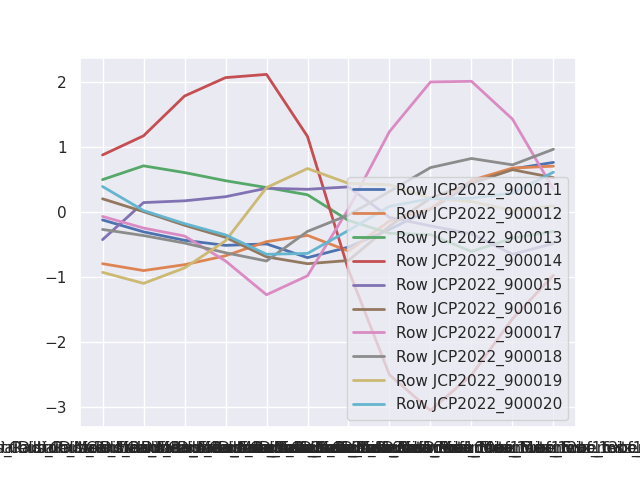

In [152]:
import pandas as pd
import matplotlib.pyplot as plt

for index, row in (
    df_rep_level_scaled2.groupby([pert_col])
    .mean()[target_columns][10:20]
    .iterrows()
):
    plt.plot(row, label=f"Row {index}")

plt.legend()
plt.show()

In [177]:
# df_rep_level_scaled2 = normalize_funcs.standardize_per_catX(
#     df_rep_level_scaled2, "batch_plate", ["slope"]
# ).copy()

df_rep_level_scaled2.groupby([pert_col]).mean()[cp_features_analysis].corr()[
    "slope"
].sort_values()

KeyboardInterrupt: 

In [184]:
# df_rep_level_scaled2 = normalize_funcs.standardize_per_catX(
#     df_rep_level_scaled2, "batch_plate", ["slope"]
# ).copy()

df_rep_level_scaled2.groupby([pert_col]).mean()[
    target_columns + ["slope"]
].corr()["slope"]

Cells_RadialDistribution_MeanFrac_mito_tubeness_5of16     0.173152
Cells_RadialDistribution_MeanFrac_mito_tubeness_6of16     0.187656
Cells_RadialDistribution_MeanFrac_mito_tubeness_7of16     0.139238
Cells_RadialDistribution_MeanFrac_mito_tubeness_8of16     0.061741
Cells_RadialDistribution_MeanFrac_mito_tubeness_9of16    -0.026766
Cells_RadialDistribution_MeanFrac_mito_tubeness_10of16   -0.144750
Cells_RadialDistribution_MeanFrac_mito_tubeness_11of16   -0.407663
Cells_RadialDistribution_MeanFrac_mito_tubeness_12of16   -0.785510
Cells_RadialDistribution_MeanFrac_mito_tubeness_13of16   -0.383967
Cells_RadialDistribution_MeanFrac_mito_tubeness_14of16   -0.052861
Cells_RadialDistribution_MeanFrac_mito_tubeness_15of16    0.174169
Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16    0.534113
slope                                                     1.000000
Name: slope, dtype: float64

In [115]:
df_rep_level_scaled = df_rep_level_scaled[
    ~df_rep_level_scaled["slope"].isnull()
]

pert_col = ds_info_dict[dataset]["pert_col"]
nOfReps = df_rep_level_scaled.groupby([pert_col]).size().reset_index()
pairWithReplicates = nOfReps.loc[nOfReps[0] != 1, :].reset_index()[pert_col]

df_rep_level_scaled2 = df_rep_level_scaled[
    df_rep_level_scaled[pert_col].isin(pairWithReplicates)
].reset_index(drop=True)

(
    cp_features,
    cp_features_analysis_0,
) = extract_cpfeature_names.extract_cpfeature_names(df_rep_level_scaled2)

cp_features_analysis = cp_features_analysis_0 + ["slope"]

df_rep_level_scaled2 = normalize_funcs.standardize_per_catX(
    df_rep_level_scaled2, "batch_plate", ["slope"]
).copy()

# df_rep_level_scaled2 = normalize_funcs.standardize_df_columns(
#     df_rep_level_scaled2, ["slope"], "Standard"
# )

DS_featureQ_rank = pd.DataFrame(
    data=df_rep_level_scaled2.groupby(pert_col)
    .std()
    .mean()[cp_features_analysis],
    index=cp_features_analysis,
    columns=["average_std_score"],
)

DS_featureQ_rank_sorted = (
    DS_featureQ_rank.sort_values(by="average_std_score")
    .reset_index()
    .rename(columns={"index": "features"})
)

print(
    dataset,
    si,
    DS_featureQ_rank_sorted["features"]
    .values.tolist()
    .index(target_columns[-1]),
    DS_featureQ_rank_sorted["features"].values.tolist().index("slope"),
)

jump_orf source_4 2897 3333


In [107]:
DS_featureQ_rank_sorted

,features,average_std_score
0,Cytoplasm_AreaShape_BoundingBoxArea,0.000936
1,Cells_AreaShape_BoundingBoxArea,0.000936
2,Cells_AreaShape_Area,0.001154
3,Cytoplasm_AreaShape_Area,0.001369
4,Nuclei_AreaShape_BoundingBoxArea,0.003192
...,...,...
3435,Cells_AreaShape_BoundingBoxMinimum_Y,12.469007
3436,Nuclei_AreaShape_BoundingBoxMaximum_Y,12.470892
3437,Nuclei_Location_Center_Y,12.474537
3438,Nuclei_AreaShape_Center_Y,12.474537


In [79]:
print(
    DS_featureQ_rank_sorted["features"]
    .values.tolist()
    .index(target_columns[-1]),
    DS_featureQ_rank_sorted["features"].values.tolist().index("slope"),
)

jump_orf source_4 2897 3364
jump_crispr source_13 3147 3177

2956 3307


In [94]:
lr = 0.01
gamma = 0.99
for i in range(200):
    lr = lr * gamma
    print(lr)

0.0099
0.009801
0.00970299
0.0096059601
0.009509900499
0.00941480149401
0.0093206534790699
0.0092274469442792
0.009135172474836408
0.009043820750088045
0.008953382542587164
0.008863848717161293
0.00877521022998968
0.008687458127689783
0.008600583546412886
0.008514577710948757
0.00842943193383927
0.008345137614500876
0.008261686238355867
0.008179069375972308
0.008097278682212584
0.00801630589539046
0.007936142836436554
0.007856781408072189
0.007778213593991467
0.007700431458051552
0.007623427143471037
0.007547192872036326
0.007471720943315963
0.007397003733882804
0.007323033696543976
0.007249803359578536
0.0071773053259827505
0.007105532272722923
0.007034476949995694
0.006964132180495737
0.00689449085869078
0.006825545950103872
0.0067572904906028335
0.006689717585696805
0.006622820409839836
0.006556592205741438
0.006491026283684023
0.006426116020847182
0.006361854860638711
0.006298236312032323
0.006235253948912
0.00617290140942288
0.006111172395328651
0.0060500606713753645
0.00598956006

In [81]:
pert_col = ds_info_dict[dataset]["pert_col"]
nOfReps = df_rep_level_scaled.groupby([pert_col]).size().reset_index()
pairWithReplicates = nOfReps.loc[nOfReps[0] != 1, :].reset_index()[pert_col]


df_rep_level_scaled2 = df_rep_level_scaled[
    df_rep_level_scaled[pert_col].isin(pairWithReplicates)
].reset_index(drop=True)

(
    cp_features,
    cp_features_analysis_0,
) = extract_cpfeature_names.extract_cpfeature_names(df_rep_level_scaled2)

cp_features_analysis = cp_features_analysis_0 + ["slope"]


df_rep_level_scaled2 = normalize_funcs.standardize_df_columns(
    df_rep_level_scaled2, cp_features_analysis, "Standard"
)

# df_rep_level_scaled2 = normalize_funcs.standardize_per_catX(
#     df_rep_level_scaled2, "batch_plate", cp_features_analysis
# ).copy()

DS_featureQ_rank = pd.DataFrame(
    data=df_rep_level_scaled2.groupby(pert_col)
    .std()
    .mean()[cp_features_analysis],
    index=cp_features_analysis,
    columns=["average_std_score"],
)

In [82]:
print(
    DS_featureQ_rank_sorted["features"]
    .values.tolist()
    .index(target_columns[-1]),
    DS_featureQ_rank_sorted["features"].values.tolist().index("slope"),
)

2956 3307


In [75]:
DS_featureQ_rank_sorted = (
    DS_featureQ_rank.sort_values(by="average_std_score")
    .reset_index()
    .rename(columns={"index": "features"})
)  # ["features"].values.tolist()#.index("slope")

In [78]:
DS_featureQ_rank_sorted["features"].values.tolist().index(target_columns[-1])

2956

In [43]:
    df_rep_level_scaled_meanSub = df_rep_level_scaled.groupby("batch_plate")[target_columns].apply(
        subtract_control
    )

    slope = df_rep_level_scaled_meanSub.apply(
        lambda x: find_end_slope(x)[1], axis=1
    )

In [48]:
slope  # .describe()

0        8.494067
1        5.142521
2        6.464353
3        3.976385
4        4.113395
           ...   
86690         NaN
86691    0.674727
86692         NaN
86693         NaN
86694         NaN
Length: 86695, dtype: float64

In [ ]:
find_end_slope(diff_pattern.values)

In [84]:
from scipy.signal import find_peaks


def find_end_slope(data, height=None):
    peaks, _ = find_peaks(data, height=height, width=1)
    valleys, _ = find_peaks(-data, height=height, width=1)
    extermas = np.concatenate((peaks, valleys))
    if extermas.size == 0:
        return np.nan, 0

    last_peak_ind = np.max(extermas)
    slope = data[-1] - data[last_peak_ind]
    return last_peak_ind, slope


def subtract_control(group):
    batch_plate = group.name
    control_values = control_df_perplate.loc[batch_plate]
    return group - control_values

## Read feature quality scores and make plots

<IPython.core.display.Javascript object>


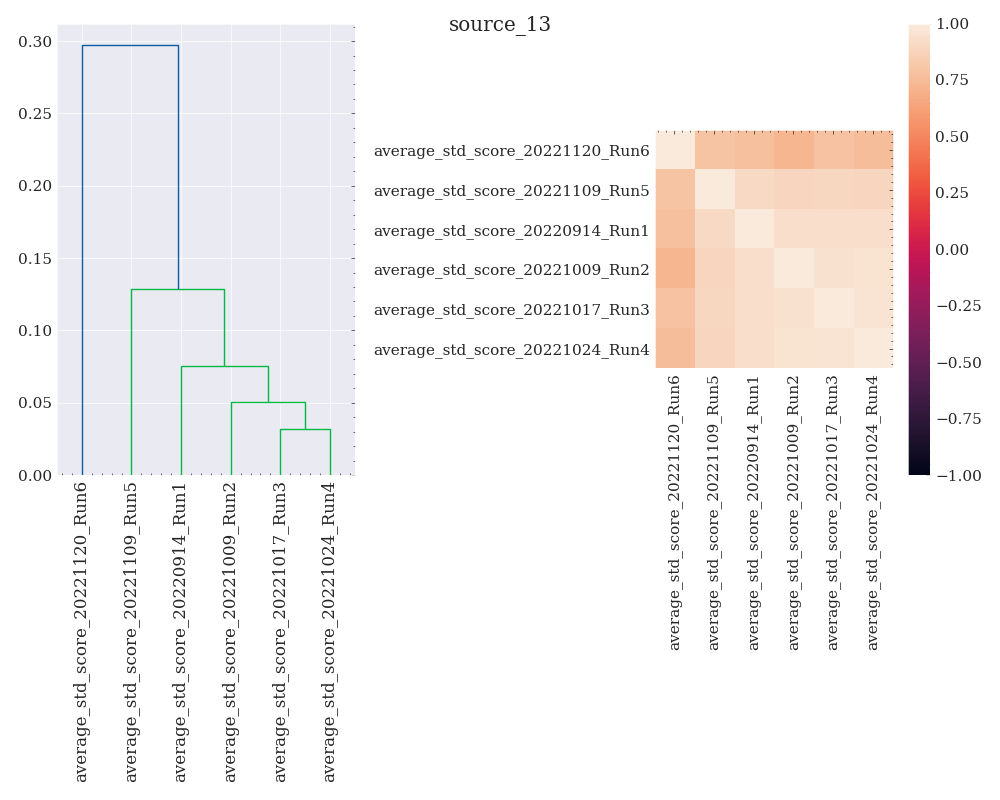

In [11]:
import scienceplots

plt.style.use(["science", "no-latex"])
# dataset = "jump_orf"
# dataset = "CDRP"
# dataset = "lincs_g"
dataset = "jump_crispr"
# dataset = "jump_compound"
# dataset = "taorf"

##################### Read preprocessed metadata
annot = pd.read_csv(
    mito_project_root_dir
    + "/workspace/metadata/preprocessed/annot_"
    + dataset
    + ".csv",
    dtype={"Metadata_Plate": str},
)


if "Metadata_Source" not in annot.columns:
    annot["Metadata_Source"] = "broad"

# target_features_list = ds_info_dict[dataset]["target_features_list"]
# sources = ['source_5']
sources = annot["Metadata_Source"].unique()
for si in sources:
    DS_X_featureQ_rank_df = pd.read_csv(
        save_results_dir
        + "/fq_csvs/"
        + dataset
        + "_feature_quality_"
        + si
        + ".csv"
    )

    batch_names_cols = DS_X_featureQ_rank_df.columns[
        DS_X_featureQ_rank_df.columns.str.contains("^average_std_score_")
    ].tolist()
    #     DS_X_featureQ_rank_df= normalize_funcs.standardize_df_columns(DS_X_featureQ_rank_df, batch_names_cols, 'Standard')

    f = cluster.check_feature_similarity_dendrogram(
        DS_X_featureQ_rank_df, batch_names_cols, (10, 8)
    )
    f.suptitle(si)
#     annot_source = annot[annot["Metadata_Source"] == si].reset_index()

In [9]:
batch_names_cols

['average_std_score_CDRP']

In [23]:
DS_X_featureQ_rank_df[
    DS_X_featureQ_rank_df.columns[
        DS_X_featureQ_rank_df.columns.str.contains("^average_std_score")
    ]
].min(axis=0)

average_std_score                  0.001564
average_std_score_20220914_Run1    0.004736
average_std_score_20221009_Run2    0.005056
average_std_score_20221017_Run3    0.004688
average_std_score_20221024_Run4    0.005735
average_std_score_20221109_Run5    0.003167
average_std_score_20221120_Run6    0.005206
dtype: float64

## Save the average values for each dataset for the reference record

In [98]:
# dataset = "jump_orf"
# dataset = "CDRP"
# dataset = "lincs_g"
# dataset = "jump_crispr"
# dataset = "jump_compound"
# dataset = "taorf"
dataset_ls = [
    "jump_orf",
    "jump_crispr",
    "jump_compound",
    "CDRP",
    "lincs_g",
    "taorf",
]

fq_dataset_ls=[]
for dataset in dataset_ls:
    ##################### Read preprocessed metadata
    annot = pd.read_csv(
        mito_project_root_dir
        + "/workspace/metadata/preprocessed/annot_"
        + dataset
        + ".csv",
        dtype={"Metadata_Plate": str},
    )

    if "Metadata_Source" not in annot.columns:
        annot["Metadata_Source"] = "broad"

    # target_features_list = ds_info_dict[dataset]["target_features_list"]
    # sources = ['source_5']
    source_fq_lsa = []
    sources = annot["Metadata_Source"].unique()
    
    for si in sources:
        DS_X_featureQ_rank_df = pd.read_csv(
            save_results_dir
            + "/fq_csvs/"
            + dataset
            + "_feature_quality_"
            + si
            + ".csv"
        )
        DS_X_featureQ_rank_df["average_std_score"]

        source_fq_lsa.append(
            DS_X_featureQ_rank_df[["features", "average_std_score"]].rename(columns={"average_std_score":"average_std_score_"+si})
        )

    sources_fq_df = reduce(lambda left,right: pd.merge(left,right,on='features', how='inner'), source_fq_lsa)
    sources_fq_df2 = sources_fq_df.median(numeric_only=True,axis=1).to_frame().rename(columns={0:dataset})
    sources_fq_df2['features']=sources_fq_df['features']
    fq_dataset_ls.append(sources_fq_df2)
    
dataset_fq_df = reduce(lambda left,right: pd.merge(left,right,on='features', how='outer'), fq_dataset_ls)
dataset_fq_df['median_across_ds']=dataset_fq_df.median(axis=1,numeric_only=True)

dataset_fq_df[["features","median_across_ds"]+dataset_ls].sort_values(by="median_across_ds").reset_index(drop=True).to_csv(save_results_dir
            + "/fq_csvs/fq_all_datasets.csv",index=False)

/tmp/ipykernel_89903/1571829778.py:19: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  annot = pd.read_csv(


In [94]:
dataset_fq_df.columns

Index(['jump_orf', 'features', 'jump_crispr', 'jump_compound', 'CDRP',
       'lincs_g', 'taorf', 'median_across_ds'],
      dtype='object')

In [27]:
# DS_X_featureQ_rank_df  # ["average_std_score"]
DS_X_featureQ_rank_df[["features", "average_std_score"]]

,features,average_std_score
0,Cytoplasm_AreaShape_BoundingBoxArea,0.001564
1,Cells_AreaShape_BoundingBoxArea,0.001564
2,Cells_AreaShape_Area,0.002692
3,Cytoplasm_AreaShape_Area,0.003671
4,Nuclei_AreaShape_BoundingBoxArea,0.006579
...,...,...
3371,Cytoplasm_AreaShape_Orientation,0.913591
3372,Cytoplasm_Granularity_15_DNA,0.926438
3373,Cells_Granularity_15_DNA,0.927955
3374,Cytoplasm_Granularity_16_DNA,0.936924


## Cross dataset feature quality match

In [66]:
from functools import reduce
import scienceplots

plt.style.use(["science", "no-latex"])

datasets = ["jump_crispr", "jump_compound", "jump_orf", "taorf", "lincs_g"]
df_ls = []
# names=[]
for dataset in datasets:
    #     names.append(dataset)
    annot = pd.read_csv(
        mito_project_root_dir
        + "/workspace/metadata/preprocessed/annot_"
        + dataset
        + ".csv",
        dtype={"Metadata_Plate": str},
    )
    if "Metadata_Source" not in annot.columns:
        annot["Metadata_Source"] = "broad"
    # target_features_list = ds_info_dict[dataset]["target_features_list"]
    # sources = ['source_5']
    sources = annot["Metadata_Source"].unique()
    for si in sources:
        file_path = (
            save_results_dir
            + "/fq_csvs/"
            + dataset
            + "_feature_quality_"
            + si
            + ".csv"
        )

        if os.path.exists(file_path):
            DS_X_featureQ_rank_df = pd.read_csv(file_path)

        #         batch_names_cols = DS_X_featureQ_rank_df.columns[
        #             DS_X_featureQ_rank_df.columns.str.contains("^average_std_score_")
        #         ].tolist()
        df_ls.append(
            DS_X_featureQ_rank_df[["features", "average_std_score"]].rename(
                columns={
                    "average_std_score": "average_std_score_"
                    + dataset
                    + "_"
                    + si
                }
            )
        )
all_datasets_df = reduce(
    lambda left, right: pd.merge(left, right, on="features", how="inner"),
    df_ls,
)

ds_names_cols = all_datasets_df.columns[
    all_datasets_df.columns.str.contains("^average_std_score_")
]
f = cluster.check_feature_similarity_dendrogram(
    all_datasets_df, ds_names_cols, (10, 8)
)

,features,average_std_score,average_std_score_2016_04_01_a549_48hr_batch1
0,Nuclei_Intensity_MADIntensity_Mito,0.051203,0.051203
1,Cells_Neighbors_SecondClosestDistance_10,0.052554,0.052554
2,Cells_Neighbors_SecondClosestDistance_Adjacent,0.052554,0.052554
3,Nuclei_Neighbors_SecondClosestDistance_2,0.054687,0.054687
4,Cells_Correlation_Manders_DNA_RNA,0.060483,0.060483
...,...,...,...
1547,Cells_AreaShape_Center_X,0.681821,0.681821
1548,Cytoplasm_Location_Center_X,0.681924,0.681924
1549,Cells_Location_Center_X,0.682057,0.682057
1550,Nuclei_Location_Center_X,0.683005,0.683005


In [30]:
cp.columns[cp.columns.str.contains("Mito|mito")]

Text(0.5, 0.98, 'd')

## Does any categories consistantly show high or low quality?

In [ ]:
Channelss = ["DNA", "RNA", "AGP", "Mito|mito", "ER"]
featureGroups = ["Texture", "Intensity", "RadialDistribution"]

all_datasets_df["across_ds_median_score"] = all_datasets_df[
    ds_names_cols
].median(axis=1)

cp = all_datasets_df.set_index("features").T
# relationMat_mpCat=pd.DataFrame(index=l1k_features)
for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):
        #         print(ch, f)

        selectedCols = cp.columns[
            cp.columns.str.contains(Channelss[ch])
            & cp.columns.str.contains(featureGroups[f])
            & cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")
        ].tolist()
        if selectedCols != []:
            all_datasets_df.loc[
                all_datasets_df["features"].isin(selectedCols),
                ["group", "channel", "family"],
            ] = (
                Channelss[ch] + "_" + featureGroups[f],
                Channelss[ch],
                featureGroups[f],
            )

Channelss = ["Nuclei", "Cytoplasm", "Cells"]
featureGroups = ["AreaShape"]

for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):
        #         print(ch, f)
        selectedCols = cp.columns[
            cp.columns.str.contains(Channelss[ch])
            & cp.columns.str.contains(featureGroups[f])
            & cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")
        ].tolist()
        if selectedCols != []:
            all_datasets_df.loc[
                all_datasets_df["features"].isin(selectedCols),
                ["group", "channel", "family"],
            ] = (
                Channelss[ch] + "_" + featureGroups[f],
                Channelss[ch],
                featureGroups[f],
            )


################## PLOT
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate medians and sort by them
medians = (
    all_datasets_df.groupby("group")["across_ds_median_score"]
    .median()
    .sort_values(ascending=True)
)
sorted_groups = medians.index
plt.figure(figsize=(8, 8))
# Plot
sns.boxplot(
    x="group",
    y="across_ds_median_score",
    data=all_datasets_df,
    order=sorted_groups,
)

plt.title("Boxplot of across_ds_median_score for Each Group")
plt.xlabel("Group")
plt.ylabel("Across DS Median Score")

# Rotate x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

## Cross-Dataset feature profile match
- "jump_orf", "jump_crispr", "taorf"

overlap_symbols size:  126 overlap_features size:  3302


<IPython.core.display.Javascript object>


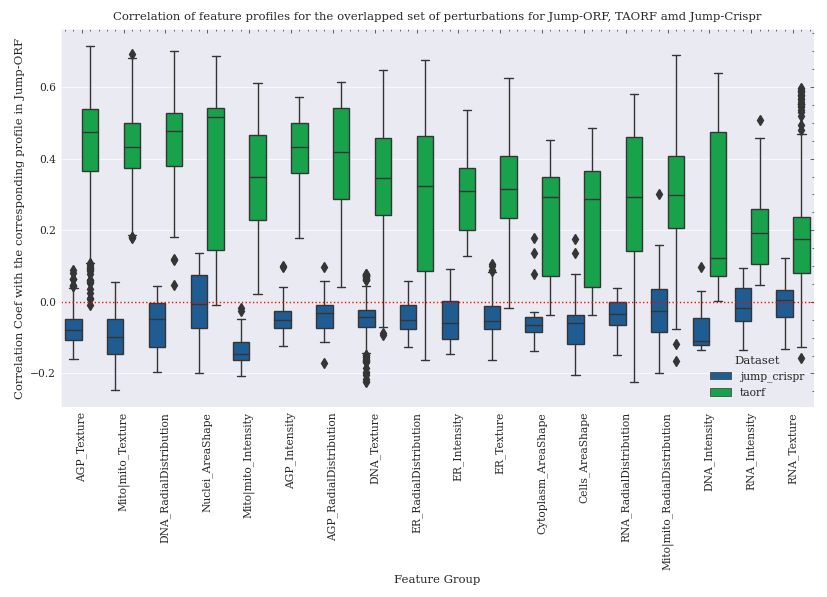

In [178]:
from functools import reduce
import scienceplots

plt.style.use(["science", "no-latex"])

datasets = ["jump_orf", "jump_crispr", "taorf"]

symbol_col = {
    "jump_crispr": "Metadata_Symbol",
    "jump_orf": "Metadata_Symbol",
    "taorf": "Metadata_gene_name",
}

df_ls = []
# names=[]
ds_symbols = {}
ds_features = {}
for dataset in datasets:
    #     names.append(dataset)
    annot = pd.read_csv(
        mito_project_root_dir
        + "/workspace/metadata/preprocessed/annot_"
        + dataset
        + ".csv",
        dtype={"Metadata_Plate": str},
    )
    if "Metadata_Source" not in annot.columns:
        annot["Metadata_Source"] = "broad"
    # target_features_list = ds_info_dict[dataset]["target_features_list"]
    # sources = ['source_5']
    sources = annot["Metadata_Source"].unique()
    for si in sources:
        file_path = (
            save_results_dir
            + "/preprocessed_data/"
            + dataset
            + "_df_rep_level_scaled_"
            + si
            + ".csv"
        )
        if os.path.exists(file_path):
            df_rep_level_scaled = pd.read_csv(file_path)

            ds_symbols[dataset] = (
                df_rep_level_scaled[symbol_col[dataset]].unique().tolist()
            )

            (
                cp_features,
                cp_features_analysis_0,
            ) = extract_cpfeature_names.extract_cpfeature_names(
                df_rep_level_scaled
            )

            ds_features[dataset] = cp_features_analysis_0

            #         batch_names_cols = DS_X_featureQ_rank_df.columns[
            #             DS_X_featureQ_rank_df.columns.str.contains("^average_std_score_")
            #         ].tolist()
            df_ls.append(df_rep_level_scaled)
        else:
            cvdsvcxvx


overlap_symbols = list(
    set.intersection(*(set(values) for values in ds_symbols.values()))
)

overlap_features = list(
    set.intersection(*(set(values) for values in ds_features.values()))
)

print(
    "overlap_symbols size: ",
    len(overlap_symbols),
    "overlap_features size: ",
    len(overlap_features),
)

ref_ds_name = "jump_orf"
ref_df = (
    df_ls[0]
    .loc[
        df_ls[0][symbol_col[ref_ds_name]].isin(overlap_symbols),
        [symbol_col[ref_ds_name]] + overlap_features,
    ]
    .reset_index(drop=True)
    .groupby(symbol_col[ref_ds_name])
    .mean()
)


cc_df_ls = []
for i, ds in enumerate(["jump_crispr", "taorf"]):
    tar_df = (
        df_ls[i + 1]
        .loc[
            df_ls[i + 1][symbol_col[ds]].isin(overlap_symbols),
            [symbol_col[ds]] + overlap_features,
        ]
        .reset_index(drop=True)
        .groupby(symbol_col[ds])
        .mean()
    )

    x = ref_df.corrwith(tar_df).reset_index(name="cc")
    x["Dataset"] = ds
    cc_df_ls.append(x)


cc_df_res = pd.concat(cc_df_ls, axis=0).rename(columns={"index": "features"})

###################
Channelss = ["DNA", "RNA", "AGP", "Mito|mito", "ER"]
featureGroups = ["Texture", "Intensity", "RadialDistribution"]

# all_datasets_df["across_ds_median_score"] = all_datasets_df[
#     ds_names_cols
# ].median(axis=1)

cp = cc_df_res.set_index("features").T
# relationMat_mpCat=pd.DataFrame(index=l1k_features)
for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):
        #         print(ch, f)

        selectedCols = cp.columns[
            cp.columns.str.contains(Channelss[ch])
            & cp.columns.str.contains(featureGroups[f])
            & cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")
        ].tolist()
        if selectedCols != []:
            cc_df_res.loc[
                cc_df_res["features"].isin(selectedCols),
                ["group", "channel", "family"],
            ] = (
                Channelss[ch] + "_" + featureGroups[f],
                Channelss[ch],
                featureGroups[f],
            )

Channelss = ["Nuclei", "Cytoplasm", "Cells"]
featureGroups = ["AreaShape"]

for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):
        #         print(ch, f)
        selectedCols = cp.columns[
            cp.columns.str.contains(Channelss[ch])
            & cp.columns.str.contains(featureGroups[f])
            & cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")
        ].tolist()
        if selectedCols != []:
            cc_df_res.loc[
                cc_df_res["features"].isin(selectedCols),
                ["group", "channel", "family"],
            ] = (
                Channelss[ch] + "_" + featureGroups[f],
                Channelss[ch],
                featureGroups[f],
            )


################## PLOT
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

sorted_groups = (
    group_medians.unstack(level="Dataset")
    .diff(axis=1)
    .sort_values(by="taorf", ascending=False)
    .index.tolist()
)

# Plot
sns.boxplot(
    x="group",
    y="cc",
    data=cc_df_res,
    hue="Dataset",
    order=sorted_groups,
)

plt.axhline(y=0, color="red", linestyle="dotted")
plt.title(
    "Correlation of feature profiles for the overlapped set of perturbations for Jump-ORF, TAORF amd Jump-Crispr"
)
plt.xlabel("Feature Group")
plt.ylabel("Correlation Coef with the corresponding profile in Jump-ORF")

# Rotate x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

- jump-compound and lincs

In [179]:
from functools import reduce
import scienceplots

plt.style.use(["science", "no-latex"])

datasets = ["jump_compound", "lincs_g"]

symbol_col = {
    "jump_compound": "Metadata_Symbol",
    "lincs_g": "Metadata_Symbol",
}

df_ls = []
# names=[]
ds_symbols = {}
ds_features = {}
for dataset in datasets:
    #     names.append(dataset)
    annot = pd.read_csv(
        mito_project_root_dir
        + "/workspace/metadata/preprocessed/annot_"
        + dataset
        + ".csv",
        dtype={"Metadata_Plate": str},
    )
    if "Metadata_Source" not in annot.columns:
        annot["Metadata_Source"] = "broad"
    # target_features_list = ds_info_dict[dataset]["target_features_list"]
    # sources = ['source_5']
    sources = annot["Metadata_Source"].unique()
    for si in sources:
        file_path = (
            save_results_dir
            + "/preprocessed_data/"
            + dataset
            + "_df_rep_level_scaled_"
            + si
            + ".csv"
        )
        if os.path.exists(file_path):
            df_rep_level_scaled = pd.read_csv(file_path)
            fsssfdf
            ds_symbols[dataset] = (
                df_rep_level_scaled[symbol_col[dataset]].unique().tolist()
            )

            (
                cp_features,
                cp_features_analysis_0,
            ) = extract_cpfeature_names.extract_cpfeature_names(
                df_rep_level_scaled
            )

            ds_features[dataset] = cp_features_analysis_0

            #         batch_names_cols = DS_X_featureQ_rank_df.columns[
            #             DS_X_featureQ_rank_df.columns.str.contains("^average_std_score_")
            #         ].tolist()
            df_ls.append(df_rep_level_scaled)
        else:
            cvdsvcxvx


overlap_symbols = list(
    set.intersection(*(set(values) for values in ds_symbols.values()))
)

overlap_features = list(
    set.intersection(*(set(values) for values in ds_features.values()))
)

print(
    "overlap_symbols size: ",
    len(overlap_symbols),
    "overlap_features size: ",
    len(overlap_features),
)

ref_ds_name = "jump_compound"
ref_df = (
    df_ls[0]
    .loc[
        df_ls[0][symbol_col[ref_ds_name]].isin(overlap_symbols),
        [symbol_col[ref_ds_name]] + overlap_features,
    ]
    .reset_index(drop=True)
    .groupby(symbol_col[ref_ds_name])
    .mean()
)


cc_df_ls = []
for i, ds in enumerate(["lincs_g"]):
    tar_df = (
        df_ls[i + 1]
        .loc[
            df_ls[i + 1][symbol_col[ds]].isin(overlap_symbols),
            [symbol_col[ds]] + overlap_features,
        ]
        .reset_index(drop=True)
        .groupby(symbol_col[ds])
        .mean()
    )

    x = ref_df.corrwith(tar_df).reset_index(name="cc")
    x["Dataset"] = ds
    cc_df_ls.append(x)


cc_df_res = pd.concat(cc_df_ls, axis=0).rename(columns={"index": "features"})

###################
Channelss = ["DNA", "RNA", "AGP", "Mito|mito", "ER"]
featureGroups = ["Texture", "Intensity", "RadialDistribution"]

# all_datasets_df["across_ds_median_score"] = all_datasets_df[
#     ds_names_cols
# ].median(axis=1)

cp = cc_df_res.set_index("features").T
# relationMat_mpCat=pd.DataFrame(index=l1k_features)
for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):
        #         print(ch, f)

        selectedCols = cp.columns[
            cp.columns.str.contains(Channelss[ch])
            & cp.columns.str.contains(featureGroups[f])
            & cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")
        ].tolist()
        if selectedCols != []:
            cc_df_res.loc[
                cc_df_res["features"].isin(selectedCols),
                ["group", "channel", "family"],
            ] = (
                Channelss[ch] + "_" + featureGroups[f],
                Channelss[ch],
                featureGroups[f],
            )

Channelss = ["Nuclei", "Cytoplasm", "Cells"]
featureGroups = ["AreaShape"]

for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):
        #         print(ch, f)
        selectedCols = cp.columns[
            cp.columns.str.contains(Channelss[ch])
            & cp.columns.str.contains(featureGroups[f])
            & cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")
        ].tolist()
        if selectedCols != []:
            cc_df_res.loc[
                cc_df_res["features"].isin(selectedCols),
                ["group", "channel", "family"],
            ] = (
                Channelss[ch] + "_" + featureGroups[f],
                Channelss[ch],
                featureGroups[f],
            )


################## PLOT
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

sorted_groups = (
    group_medians.unstack(level="Dataset")
    .diff(axis=1)
    .sort_values(by="taorf", ascending=False)
    .index.tolist()
)

# Plot
sns.boxplot(
    x="group",
    y="cc",
    data=cc_df_res,
    hue="Dataset",
    order=sorted_groups,
)

plt.axhline(y=0, color="red", linestyle="dotted")
plt.title(
    "Correlation of feature profiles for the overlapped set of perturbations for Jump-ORF, TAORF amd Jump-Crispr"
)
plt.xlabel("Feature Group")
plt.ylabel("Correlation Coef with the corresponding profile in Jump-ORF")

# Rotate x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

NameError: name 'fsssfdf' is not defined

In [186]:
df_rep_level_scaled[
    df_rep_level_scaled.columns[
        df_rep_level_scaled.columns.str.contains("Metada")
    ]
]

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_PlateType
0,source_1,UL000081,A02,Batch4_20221012,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,COMPOUND
1,source_1,UL000081,A03,Batch4_20221012,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,COMPOUND
2,source_1,UL000081,A04,Batch4_20221012,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,COMPOUND
3,source_1,UL000081,A05,Batch4_20221012,JCP2022_047857,KYVAFSAMGPNOIA-UHFFFAOYSA-N,InChI=1S/C23H18FNO4S/c1-2-10-29-16-5-3-4-14(11...,COMPOUND
4,source_1,UL000081,A06,Batch4_20221012,JCP2022_072229,QAVAMIPQKRZGGW-UHFFFAOYSA-N,InChI=1S/C19H24N2O5/c1-5-21(19(22)12-6-7-12)11...,COMPOUND
...,...,...,...,...,...,...,...,...
74044,source_1,UL001781,Z43,Batch5_20221030,JCP2022_064404,OKPPTOAERRHVKW-UHFFFAOYSA-N,InChI=1S/C21H25NO2/c1-22(18-7-3-2-4-8-18)15-16...,COMPOUND
74045,source_1,UL001781,Z44,Batch5_20221030,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,COMPOUND
74046,source_1,UL001781,Z45,Batch5_20221030,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,COMPOUND
74047,source_1,UL001781,Z46,Batch5_20221030,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,COMPOUND


In [152]:
sources = annot["Metadata_Source"].unique()

In [169]:
Metadata_JCP2022

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_circles
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import ExtraTreesClassifier, RandomTreesEmbedding
from sklearn.naive_bayes import BernoulliNB

# make a synthetic dataset
X, y = make_circles(factor=0.5, random_state=0, noise=0.05)

# use RandomTreesEmbedding to transform data
hasher = RandomTreesEmbedding(n_estimators=10, random_state=0, max_depth=3)
X_transformed = hasher.fit_transform(X)

# Visualize result after dimensionality reduction using truncated SVD
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X_transformed)

# Learn a Naive Bayes classifier on the transformed data
nb = BernoulliNB()
nb.fit(X_transformed, y)


# Learn an ExtraTreesClassifier for comparison
trees = ExtraTreesClassifier(max_depth=3, n_estimators=10, random_state=0)
trees.fit(X, y)

ExtraTreesClassifier(max_depth=3, n_estimators=10, random_state=0)

In [7]:
X_transformed

<100x74 sparse matrix of type '<class 'numpy.float64'>'
	with 1000 stored elements in Compressed Sparse Row format>

In [2]:
X_transformed.shape

(100, 74)

In [3]:
X.shape

(100, 2)

In [4]:
X_transformed

<100x74 sparse matrix of type '<class 'numpy.float64'>'
	with 1000 stored elements in Compressed Sparse Row format>

In [14]:
# Imports
import numpy as np
import rcca

# Initialize number of samples
nSamples = 1000

# Define two latent variables (number of samples x 1)
latvar1 = np.random.randn(nSamples,40)
latvar2 = np.random.randn(nSamples,50)

# Define independent components for each dataset (number of observations x dataset dimensions)
indep1 = np.random.randn(nSamples, 40)
indep2 = np.random.randn(nSamples, 50)

# Create two datasets, with each dimension composed as a sum of 75% one of the latent variables and 25% independent component
data1 = 0.25*indep1 + 0.75*latvar1;#np.vstack((latvar1, latvar2, latvar1, latvar2)).T
data2 = 0.25*indep2 + 0.75*latvar2;#*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T

# Split each dataset into two halves: training set and test set
train1 = data1[:int(nSamples/2)]
train2 = data2[:int(nSamples/2)]
test1 = data1[int(nSamples/2):]
test2 = data2[int(nSamples/2):]

# Create a cca object as an instantiation of the CCA object class. 
cca = rcca.CCA(kernelcca = False, reg = 0., numCC = 20)

# Use the train() method to find a CCA mapping between the two training sets.
cca.train([train1, train2])

# Use the validate() method to test how well the CCA mapping generalizes to the test data.
# For each dimension in the test data, correlations between predicted and actual data are computed.
# testcorrs = cca.validate([test1, test2])

Training CCA, kernel = None, regularization = 0.0000, 20 components


In [17]:
cca.cancorrs

array([0.56254949, 0.5148938 , 0.49930242, 0.49025329, 0.47362422,
       0.46557275, 0.44344999, 0.42403057, 0.41823775, 0.39169949,
       0.38122428, 0.36083613, 0.35748098, 0.350504  , 0.34523584,
       0.31923093, 0.30067551, 0.29565051, 0.29031012, 0.27457704])

In [13]:
cca.comps[0].shape, train1.shape

((500, 20), (500, 40))

In [20]:
np.concatenate(cca.comps,axis=1).shape

(500, 40)

In [1]:
from mofapy2.run.entry_point import entry_point